In [1]:
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.MLP import create_mlp
import itertools
import pandas as pd


In [4]:
def load(f):
    # Move up one directory when loading the data
    file_path = os.path.join('..', f)
    return np.load(file_path)['arr_0']

# Load the data
X_train = load('kmnist-train-imgs.npz').reshape(-1, 28*28) / 255.0
x_test = load('kmnist-test-imgs.npz').reshape(-1, 28*28) / 255.0
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

# Reshape the data for input layer
X_train = X_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [8]:
# Define the input shape and number of classes
input_shape = X_train.shape[1:]  # 784 for KMNIST
num_classes = y_train.max() + 1

print(input_shape, num_classes)


(28, 28, 1) 10


Testing Model ID 1: Architecture: {0: 2000}, Dropout: 0.0, Optimizer: adam, Learning Rate: 0.001, Activation: relu
Epoch 1/20
844/844 [==============================] - 8s 9ms/step - loss: 0.3075 - accuracy: 0.9061 - val_loss: 0.1796 - val_accuracy: 0.9463
Epoch 2/20
844/844 [==============================] - 7s 8ms/step - loss: 0.1192 - accuracy: 0.9652 - val_loss: 0.1458 - val_accuracy: 0.9528
Epoch 3/20
758/844 [=========================>....] - ETA: 0s - loss: 0.0619 - accuracy: 0.9815

KeyboardInterrupt: 

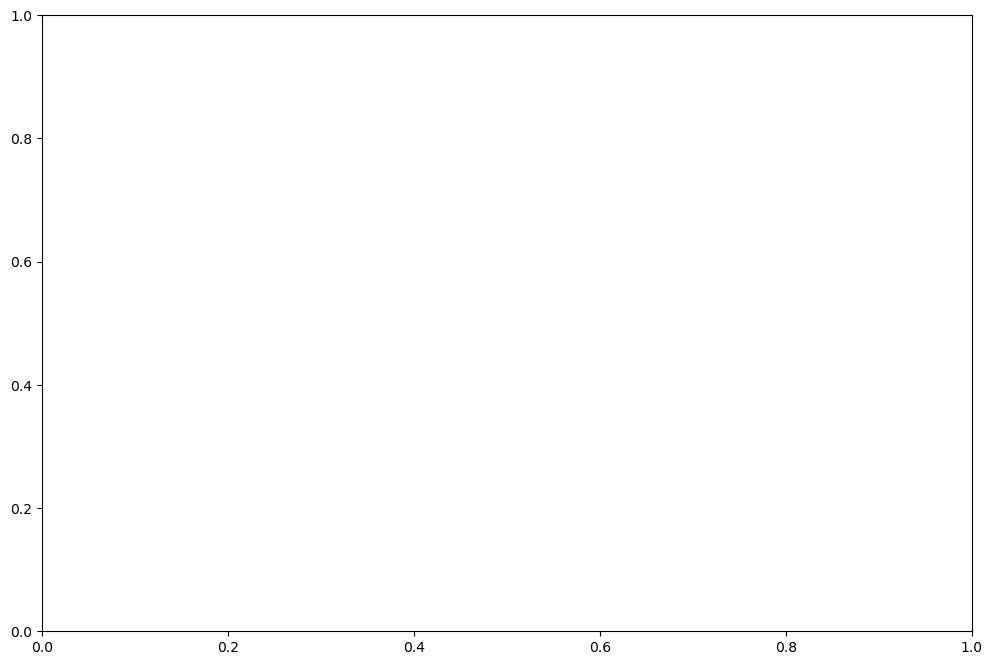

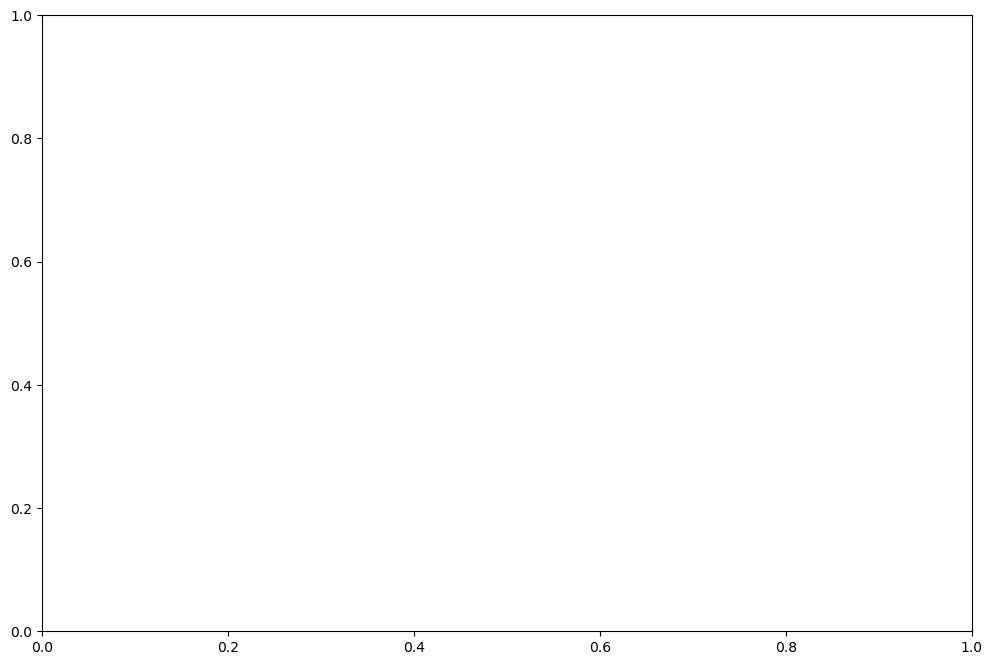

In [9]:
# Define a range of hyperparameters to test
architectures = [
    {0: 2000},
    {0: 1000, 1: 1000},
    {0: 500, 1: 1000, 2: 500},
]
dropout_rates = [0.0, 0.5]
optimizers = ['adam']
learning_rates = [0.001, 0.01]
activations = ['relu', 'tanh']

# Store results
results = []
best_model = None

# Generate all combinations of hyperparameters
hyperparameter_configs = list(itertools.product(architectures, dropout_rates, optimizers, learning_rates, activations))

# Create figures for learning curves with larger size
fig_train, ax_train = plt.subplots(figsize=(12, 8))
fig_val, ax_val = plt.subplots(figsize=(12, 8))

# Test different combinations
model_id = 0
epochs=20
for arch, dropout_rate, optimizer, lr, activation in hyperparameter_configs:
   
    model_id += 1
    print(f"Testing Model ID {model_id}: Architecture: {arch}, Dropout: {dropout_rate}, Optimizer: {optimizer}, Learning Rate: {lr}, Activation: {activation}")
    # Create the MLP model
    model = create_mlp(input_shape, num_classes, arch, activation=activation, learning_rate=lr, optimizer=optimizer, dropout_rate=dropout_rate)
    
    # Define callback for early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=64,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Confuison matrix for each model
    y_pred = model.predict(x_val)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    plt.title(f'Model_{model_id} Confusion Matrix')
    disp.plot()
    plt.savefig(f'confusion_matrix/model_{model_id}.png')
    plt.close()
    
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    # Save the best model based on validation accuracy
    if not best_model or history.history['val_accuracy'][-1] > best_model['val_accuracy']:
        best_model = {
            'model_id': model_id,
            'architecture': arch,
            'dropout_rate': dropout_rate,
            'optimizer': optimizer,
            'learning_rate': lr,
            'activation': activation,
            'val_accuracy': history.history['val_accuracy'][-1],
            'epochs_trained': len(history.history['val_accuracy']),
            'val_loss': history.history['val_loss'][-1]
        }
        model.save('best_model.h5')
    
    # Create list for validation learning curve
    val_learning_curve = []
    val_learning_curve.append(history.history['val_accuracy'])

    # Save the results
    results.append({
        'model_id': model_id,
        'architecture': arch,
        'dropout_rate': dropout_rate,
        'optimizer': optimizer,
        'learning_rate': lr,
        'activation': activation,
        'val_accuracy': max(history.history['val_accuracy']),
        'val_loss': min(history.history['val_loss']),
        'epochs_trained': len(history.history['val_loss']),
        'val_learning curve' : val_learning_curve,
        'test_accuracy': accuracy_score(y_test, y_pred),
    })

    # Plot learning curves for each model iteration
    ax_train.plot(history.history['accuracy'], label=f'Model_{model_id}_train')
    ax_val.plot(history.history['val_accuracy'], label=f'Model_{model_id}_val')
    
    

# Finalize and show the plots
ax_train.set_title('Training Accuracy Curve')
ax_train.set_xlabel('Epoch')
ax_train.set_ylabel('Accuracy')
ax_train.legend()

ax_val.set_title('Validation Accuracy Curve')
ax_val.set_xlabel('Epoch')
ax_val.set_ylabel('Accuracy')
ax_val.legend()

plt.show()

# Save results to json
with open('results.json', 'w') as f:
    json.dump(results, f)

# Find the best model
best_model = min(results, key=lambda x: x['val_loss'])

print("\nBest Model Configuration:")
print(f"Model ID: {best_model['model_id']}")
print(f"Architecture: {best_model['architecture']}")
print(f"Dropout Rate: {best_model['dropout_rate']}")
print(f"Optimizer: {best_model['optimizer']}")
print(f"Learning Rate: {best_model['learning_rate']}")
print(f"Activation: {best_model['activation']}")
print(f"Best Validation Accuracy: {best_model['val_accuracy']:.4f}")
print(f"Best Validation Loss: {best_model['val_loss']:.4f}")
print(f"Epochs Trained: {best_model['epochs_trained']}")

In [ ]:
# Load Json file
with open('results.json') as f:
    data = json.load(f)

# Print test accuracy for each model
for model in data:
    print(f"Model ID: {model['model_id']}, Test Accuracy: {model['test_accuracy']:.4f}")

In [33]:

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print(f"\nBest Model Test Accuracy: {test_accuracy:.4f}")
print(f"Best Model Test Loss: {test_loss:.4f}")


Best Model Test Accuracy: 0.9248
Best Model Test Loss: 0.3207
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_28 (Dense)            (None, 1000)              785000    
                                                                 
 dropout_16 (Dropout)        (None, 1000)              0         
                                                                 
 dense_29 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_17 (Dropout)        (None, 1000)              0         
                                                                 
 dense_30 (Dense)            (None, 10)                10010     
                                                        

## Data Augmentations

In [12]:
def cutout(image, mask_size=16, num_cutouts=1):
    """Applies Cutout augmentation to an image."""
    h, w, _ = image.shape
    image_copy = image.copy()

    for _ in range(num_cutouts):
        x = np.random.randint(0, w)
        y = np.random.randint(0, h)

        # Ensure the cutout does not go out of bounds
        x1 = np.clip(x - mask_size // 2, 0, w)
        x2 = np.clip(x + mask_size // 2, 0, w)
        y1 = np.clip(y - mask_size // 2, 0, h)
        y2 = np.clip(y + mask_size // 2, 0, h)

        # Set the cutout region to the mean value of the image
        mask_color = np.mean(image_copy)
        image_copy[y1:y2, x1:x2, :] = mask_color

    return image_copy

# Random noise
def add_random_noise(image, noise_factor=0.1):
    """Adds random noise to an image."""
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    return np.clip(noisy_image, 0.0, 1.0)

def add_radial_noise(image, noise_factor=0.1):
    """Adds radial noise to an image."""
    h, w, _ = image.shape
    center_y, center_x = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    max_dist = np.sqrt(center_x**2 + center_y**2)
    normalized_dist = dist_from_center / max_dist
    noise = np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    radial_noise = noise * normalized_dist[:, :, np.newaxis] * noise_factor
    noisy_image = image + radial_noise
    return np.clip(noisy_image, 0.0, 1.0)

def add_mask(image, mask_size=16, num_masks=1):
    """Adds random masks to an image."""
    masked_image = image.copy()
    h, w, _ = image.shape
    for _ in range(num_masks):
        y = np.random.randint(0, h - mask_size)
        x = np.random.randint(0, w - mask_size)
        masked_image[y:y+mask_size, x:x+mask_size, :] = 0
    return masked_image

def add_random_noise_mask(image):
    altered_image = add_random_noise(image)
    altered_image = add_mask(altered_image)
    return altered_image

datagen_rand_noise = ImageDataGenerator(
    preprocessing_function=add_random_noise  # Noise injection
)

# Radial noise
datagen_radial_noise = ImageDataGenerator(
    preprocessing_function=add_radial_noise  # Radial noise injection
)

# Flip
datagen_flip = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)

# Zoom
datagen_zoom = ImageDataGenerator(
    zoom_range=0.5 # Zoom in on the image
)

# Mask
datagen_mask = ImageDataGenerator(
    preprocessing_function = cutout  # Zoom in on the image
)

# Random noise and zoom
datagen_rand_noise_zoom = ImageDataGenerator(
    preprocessing_function=add_random_noise,  # Noise injection
    zoom_range=0.1 # Zoom in on the image
)

# Random noise and mask
datagen_rand_noise_mask = ImageDataGenerator(
    preprocessing_function=add_random_noise_mask,  # Noise injection
)

# No noise
datagen_no_noise = ImageDataGenerator()

Text(0.5, 1.0, 'Noise + Mask')

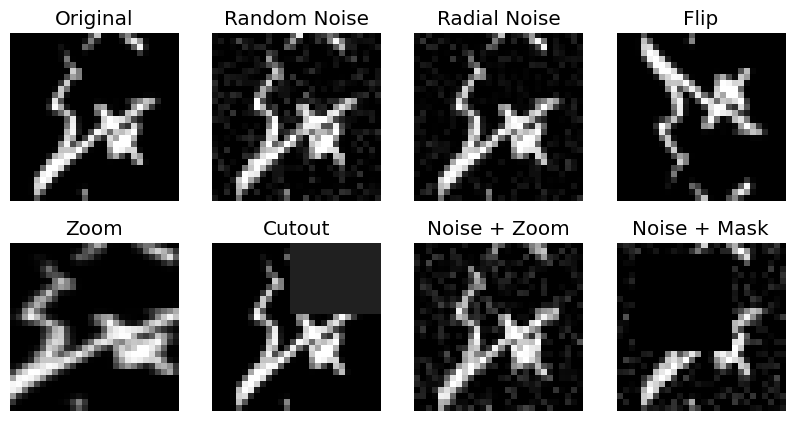

In [13]:
# Get a sample image
sample_image = x_train[0]
img_arr = img_to_array(sample_image) 
img_arr = img_arr.reshape((1,) + img_arr.shape)
# Apply different augmentations
augmented_images = []
# For the other augmentations, we can use the existing datagenerators

# Apply each datagen separately to the same image
augmented_images.append(img_arr)  # Original image

# Random Noise
augmented_images.append(datagen_rand_noise.flow(img_arr, batch_size=1))

# Radial Noise
augmented_images.append(datagen_radial_noise.flow(img_arr, batch_size=1))

# Flip
augmented_images.append(datagen_flip.flow(img_arr, batch_size=1))

# Zoom
augmented_images.append(datagen_zoom.flow(img_arr, batch_size=1))

# Mask (Cutout)
augmented_images.append(datagen_mask.flow(img_arr, batch_size=1))

# Random Noise + Zoom
augmented_images.append(datagen_rand_noise_zoom.flow(img_arr, batch_size=1))

# No Augmentation
augmented_images.append(datagen_rand_noise_mask.flow(img_arr, batch_size=1))

f, xyarr = plt.subplots(2, 4, figsize=(10, 5))
for ax in xyarr.flat:
    ax.axis('off')  # This removes all axes, including scale bars
plt.rcParams.update({'font.size': 12})  # Increase font size
xyarr[0,0].imshow(augmented_images[0][0].squeeze(), cmap='gray')
xyarr[0,0].set_title('Original')
xyarr[0,1].imshow(augmented_images[1][0].squeeze(), cmap='gray')
xyarr[0,1].set_title('Random Noise')
xyarr[0,2].imshow(augmented_images[2][0].squeeze(), cmap='gray')
xyarr[0,2].set_title('Radial Noise')
xyarr[0,3].imshow(augmented_images[3][0].squeeze(), cmap='gray')
xyarr[0,3].set_title('Flip')    
xyarr[1,0].imshow(augmented_images[4][0].squeeze(), cmap='gray')
xyarr[1,0].set_title('Zoom')
xyarr[1,1].imshow(augmented_images[5][0].squeeze(), cmap='gray')
xyarr[1,1].set_title('Cutout')
xyarr[1,2].imshow(augmented_images[6][0].squeeze(), cmap='gray')
xyarr[1,2].set_title('Noise + Zoom')
xyarr[1,3].imshow(augmented_images[7][0].squeeze(), cmap='gray')
xyarr[1,3].set_title('Noise + Mask')



In [20]:
# Load json file
with open(r'C:\Users\patri\git\DeepLearning\DL-Project1\testing\MLP\earlystopping\results.json') as f:
    results = json.load(f)

# Load best model from h5 file # Change to best hyper parameters to train from scratch 
best_model_rand_noise = create_mlp(input_shape=input_shape, num_classes=num_classes, layer_units=results[0]['architecture'], activation=results[0]['activation'], learning_rate=results[0]['learning_rate'], optimizer=results[0]['optimizer'], dropout_rate=results[0]['dropout_rate'])
best_model_radial_noise = create_mlp(input_shape=input_shape, num_classes=num_classes, layer_units=results[0]['architecture'], activation=results[0]['activation'], learning_rate=results[0]['learning_rate'], optimizer=results[0]['optimizer'], dropout_rate=results[0]['dropout_rate'])
best_model_flip = create_mlp(input_shape=input_shape, num_classes=num_classes, layer_units=results[0]['architecture'], activation=results[0]['activation'], learning_rate=results[0]['learning_rate'], optimizer=results[0]['optimizer'], dropout_rate=results[0]['dropout_rate'])
best_model_zoom = create_mlp(input_shape=input_shape, num_classes=num_classes, layer_units=results[0]['architecture'], activation=results[0]['activation'], learning_rate=results[0]['learning_rate'], optimizer=results[0]['optimizer'], dropout_rate=results[0]['dropout_rate'])
best_model_mask = create_mlp(input_shape=input_shape, num_classes=num_classes, layer_units=results[0]['architecture'], activation=results[0]['activation'], learning_rate=results[0]['learning_rate'], optimizer=results[0]['optimizer'], dropout_rate=results[0]['dropout_rate'])
best_model_rand_noise_zoom = create_mlp(input_shape=input_shape, num_classes=num_classes, layer_units=results[0]['architecture'], activation=results[0]['activation'], learning_rate=results[0]['learning_rate'], optimizer=results[0]['optimizer'], dropout_rate=results[0]['dropout_rate'])
best_model_rand_noise_mask = create_mlp(input_shape=input_shape, num_classes=num_classes, layer_units=results[0]['architecture'], activation=results[0]['activation'], learning_rate=results[0]['learning_rate'], optimizer=results[0]['optimizer'], dropout_rate=results[0]['dropout_rate'])
best_model_no_noise = create_mlp(input_shape=input_shape, num_classes=num_classes, layer_units=results[0]['architecture'], activation=results[0]['activation'], learning_rate=results[0]['learning_rate'], optimizer=results[0]['optimizer'], dropout_rate=results[0]['dropout_rate'])

# Create a new ImageDataGenerator for validation data
datagen_val = ImageDataGenerator()

# Wrap the datagen with our custom generator
train_generator_rand_noise = datagen_rand_noise.flow(x_train, y_train, batch_size=32)
train_generator_radial_noise = datagen_radial_noise.flow(x_train, y_train, batch_size=32)
train_generator_flip = datagen_flip.flow(x_train, y_train, batch_size=32)
train_generator_zoom = datagen_zoom.flow(x_train, y_train, batch_size=32)
train_generator_mask = datagen_mask.flow(x_train, y_train, batch_size=32)
train_generator_rand_noise_zoom = datagen_rand_noise_zoom.flow(x_train, y_train, batch_size=32)
train_generator_rand_noise_mask = datagen_rand_noise_mask.flow(x_train, y_train, batch_size=32)
train_generator_no_noise = datagen_no_noise.flow(x_train, y_train, batch_size=32)
val_generator = datagen_val.flow(x_val, y_val, batch_size=32)

# Train the model with custom augmentation
augmentation_loss_df = pd.DataFrame()
augmentation_accuracy_df = pd.DataFrame()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
epochs=15

# Random noise
history_rand_noise = best_model_rand_noise.fit(train_generator_rand_noise,
                        epochs=epochs,
                        validation_data=val_generator,  
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_rand_noise.history['val_loss'][-1]
last_val_accuracy = history_rand_noise.history['val_accuracy'][-1]
for _ in range(len(history_rand_noise.history['val_loss']), 16):
    history_rand_noise.history['val_loss'].append(last_val_loss)
    history_rand_noise.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"rand_noise"] = history_rand_noise.history['val_loss']
augmentation_accuracy_df[f"rand_noise"] = history_rand_noise.history['val_accuracy']

# Radial noise
history_radial_noise = best_model_radial_noise.fit(train_generator_radial_noise,
                        epochs=epochs,
                        validation_data=val_generator,  
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_radial_noise.history['val_loss'][-1]
last_val_accuracy = history_radial_noise.history['val_accuracy'][-1]
for _ in range(len(history_radial_noise.history['val_loss']), 16):
    history_radial_noise.history['val_loss'].append(last_val_loss)
    history_radial_noise.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"radial_noise"] = history_radial_noise.history['val_loss']
augmentation_accuracy_df[f"radial_noise"] = history_radial_noise.history['val_accuracy']


# Flip
history_flip = best_model_flip.fit(train_generator_flip,
                        epochs=epochs,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_flip.history['val_loss'][-1]
last_val_accuracy = history_flip.history['val_accuracy'][-1]
for _ in range(len(history_flip.history['val_loss']), 16):
    history_flip.history['val_loss'].append(last_val_loss)
    history_flip.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"flip"] = history_flip.history['val_loss']
augmentation_accuracy_df[f"flip"] = history_flip.history['val_accuracy']

# Zoom
history_zoom = best_model_zoom.fit(train_generator_zoom,
                        epochs=epochs,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_zoom.history['val_loss'][-1]
last_val_accuracy = history_zoom.history['val_accuracy'][-1]
for _ in range(len(history_zoom.history['val_loss']), 16):
    history_zoom.history['val_loss'].append(last_val_loss)
    history_zoom.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"zoom"] = history_zoom.history['val_loss']
augmentation_accuracy_df[f"zoom"] = history_zoom.history['val_accuracy']

# Mask
history_mask = best_model_mask.fit(train_generator_mask,
                        epochs=epochs,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_mask.history['val_loss'][-1]
last_val_accuracy = history_mask.history['val_accuracy'][-1]
for _ in range(len(history_mask.history['val_loss']), 16):
    history_mask.history['val_loss'].append(last_val_loss)
    history_mask.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"mask"] = history_mask.history['val_loss']
augmentation_accuracy_df[f"mask"] = history_mask.history['val_accuracy']

# Rand noise and zoom
history_rand_noise_zoom = best_model_rand_noise_zoom.fit(train_generator_rand_noise_zoom,
                        epochs=epochs,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_rand_noise_zoom.history['val_loss'][-1]
last_val_accuracy = history_rand_noise_zoom.history['val_accuracy'][-1]
for _ in range(len(history_rand_noise_zoom.history['val_loss']), 16):
    history_rand_noise_zoom.history['val_loss'].append(last_val_loss)
    history_rand_noise_zoom.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"rand_noise_zoom"] = history_rand_noise_zoom.history['val_loss']
augmentation_accuracy_df[f"rand_noise_zoom"] = history_rand_noise_zoom.history['val_accuracy']

# Random noise and mask
history_rand_noise_mask = best_model_rand_noise_mask.fit(train_generator_rand_noise_mask,
                        epochs=epochs,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_rand_noise_mask.history['val_loss'][-1]
last_val_accuracy = history_rand_noise_mask.history['val_accuracy'][-1]
for _ in range(len(history_rand_noise_mask.history['val_loss']), 16):
    history_rand_noise_mask.history['val_loss'].append(last_val_loss)
    history_rand_noise_mask.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"rand_noise_mask"] = history_rand_noise_mask.history['val_loss']
augmentation_accuracy_df[f"rand_noise_mask"] = history_rand_noise_mask.history['val_accuracy']

# No noise
history_no_noise = best_model_no_noise.fit(train_generator_no_noise,
                        epochs=epochs,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_no_noise.history['val_loss'][-1]
last_val_accuracy = history_no_noise.history['val_accuracy'][-1]
for _ in range(len(history_no_noise.history['val_loss']), 16):
    history_no_noise.history['val_loss'].append(last_val_loss)
    history_no_noise.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"no_noise"] = history_no_noise.history['val_loss']
augmentation_accuracy_df[f"no_noise"] = history_no_noise.history['val_accuracy']

# Save the dataframes to CSV files
augmentation_loss_df.to_csv('augmentation_loss.csv', index=False)
augmentation_accuracy_df.to_csv('augmentation_accuracy.csv', index=False)



Epoch 1/15
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4614 - accuracy: 0.8612 - val_loss: 0.2912 - val_accuracy: 0.9080
Epoch 2/15
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2306 - accuracy: 0.9318 - val_loss: 0.2174 - val_accuracy: 0.9327
Epoch 3/15
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1666 - accuracy: 0.9520 - val_loss: 0.2032 - val_accuracy: 0.9378
Epoch 4/15
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1288 - accuracy: 0.9621 - val_loss: 0.2106 - val_accuracy: 0.9365
Epoch 5/15
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1051 - accuracy: 0.9684 - val_loss: 0.1761 - val_accuracy: 0.9480
Epoch 6/15
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0871 - accuracy: 0.9742 - val_loss: 0.2023 - val_accuracy: 0.9432
Epoch 7/15
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0710 - accuracy: 0.9787 - val_loss: 0.2247 - val_accuracy:

In [23]:
rand_noise_loss, rand_noise_accuracy = best_model_rand_noise.evaluate(x_test, y_test, verbose=0)
print(f"Rand noise test accuracy: {rand_noise_accuracy:.4f}")
print(f"Rand noise test loss: {rand_noise_loss:.4f}")
radial_noise_loss, radial_noise_accuracy = best_model_radial_noise.evaluate(x_test, y_test, verbose=0)
print(f"Radial noise test accuracy: {radial_noise_accuracy:.4f}")
print(f"Radial noise test loss: {radial_noise_loss:.4f}")
flip_loss, flip_accuracy = best_model_flip.evaluate(x_test, y_test, verbose=0)
print(f"Flip test accuracy: {flip_accuracy:.4f}")
print(f"Flip test loss: {flip_loss:.4f}")
zoom_loss, zoom_accuracy = best_model_zoom.evaluate(x_test, y_test, verbose=0)
print(f"Zoom test accuracy: {zoom_accuracy:.4f}")
print(f"Zoom test loss: {zoom_loss:.4f}")
mask_loss, mask_accuracy = best_model_mask.evaluate(x_test, y_test, verbose=0)
print(f"Mask test accuracy: {mask_accuracy:.4f}")
print(f"Mask test loss: {mask_loss:.4f}")
rand_noise_zoom_loss, rand_noise_zoom_accuracy = best_model_rand_noise_zoom.evaluate(x_test, y_test, verbose=0)
print(f"Rand noise and zoom test accuracy: {rand_noise_zoom_accuracy:.4f}")
print(f"Rand noise and zoom test loss: {rand_noise_zoom_loss:.4f}")
rand_noise_mask_loss, rand_noise_mask_accuracy = best_model_rand_noise_mask.evaluate(x_test, y_test, verbose=0)
print(f"Rand noise and mask test accuracy: {rand_noise_mask_accuracy:.4f}")
print(f"Rand noise and mask test loss: {rand_noise_mask_loss:.4f}")
no_noise_loss, no_noise_accuracy = best_model_no_noise.evaluate(x_test, y_test, verbose=0)
print(f"No noise test accuracy: {no_noise_accuracy:.4f}")
print(f"No noise test loss: {no_noise_loss:.4f}") 

# List of accuracies where elements are tupels of the name of the augmentation and the accuracy
accuracies = [('rand_noise', rand_noise_accuracy), ('radial_noise', radial_noise_accuracy), ('flip', flip_accuracy), ('zoom', zoom_accuracy), ('mask', mask_accuracy), ('rand_noise_zoom', rand_noise_zoom_accuracy), ('rand_noise_mask', rand_noise_mask_accuracy), ('no_noise', no_noise_accuracy)]

# Get best accuracy
best_accuracy = max(accuracies, key=lambda x: x[1])
print(f"\nBest accuracy: {best_accuracy[1]:.4f} with augmentation: {best_accuracy[0]}")


Rand noise test accuracy: 0.8755
Rand noise test loss: 0.7229
Radial noise test accuracy: 0.8804
Radial noise test loss: 0.6837
Flip test accuracy: 0.7892
Flip test loss: 0.7381
Zoom test accuracy: 0.8650
Zoom test loss: 0.4711
Mask test accuracy: 0.8823
Mask test loss: 0.5029
Rand noise and zoom test accuracy: 0.8940
Rand noise and zoom test loss: 0.5300
Rand noise and mask test accuracy: 0.8257
Rand noise and mask test loss: 0.7325
No noise test accuracy: 0.8915
No noise test loss: 0.6355

Best accuracy: 0.8940 with augmentation: rand_noise_zoom


In [24]:
import datetime
# List of models and their names
models = [
    (best_model_rand_noise, "Random Noise"),
    (best_model_radial_noise, "Radial Noise"),
    (best_model_flip, "Flip"),
    (best_model_zoom, "Zoom"),
    (best_model_mask, "Mask"),
    (best_model_rand_noise_zoom, "Random Noise + Zoom"),
    (best_model_rand_noise_mask, "Random Noise + Mask"),
    (best_model_no_noise, "No Noise")
]

# Create and save confusion matrices for each model
for model, name in models:
    # Predictions on the test set
    y_pred = model.predict(x_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # Confusion matrix
    confusion = confusion_matrix(y_test, y_pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)
    plt.title(f'Confusion Matrix for {name}')
    
    # Save the figure
    now = datetime.datetime.now()
    plt.savefig(f'Aug_CMs/confusion_matrix_{name.replace(" ", "_").lower()}_{now.strftime("%Y-%m-%d")}.png')
    plt.close()

313/313 [==============================] - 0s 1ms/step


In [34]:
# Update the number of epochs
epochs = 100

# Create new DataFrames for the results
new_augmentation_loss_df = pd.DataFrame()
new_augmentation_accuracy_df = pd.DataFrame()

# Create a new ImageDataGenerator for validation data
datagen_val = ImageDataGenerator()

# Wrap the datagen with our custom generator
train_generator_mask = datagen_mask.flow(x_train, y_train, batch_size=32)
train_generator_rand_noise_zoom = datagen_rand_noise_zoom.flow(x_train, y_train, batch_size=32)
val_generator = datagen_val.flow(x_val, y_val, batch_size=32)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Mask
history_mask_long = best_model_mask.fit(train_generator_mask,
                        epochs=epochs,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=early_stopping
                        )
last_val_loss = history_mask_long.history['val_loss'][-1]
last_val_accuracy = history_mask_long.history['val_accuracy'][-1]
for _ in range(len(history_mask_long.history['val_loss']), 101):
    history_mask_long.history['val_loss'].append(last_val_loss)
    history_mask_long.history['val_accuracy'].append(last_val_accuracy)
new_augmentation_loss_df[f"mask"] = history_mask_long.history['val_loss']
new_augmentation_accuracy_df[f"mask"] = history_mask_long.history['val_accuracy']

# Rand noise and zoom
history_rand_noise_zoom_long = best_model_rand_noise_zoom.fit(train_generator_rand_noise_zoom,
                        epochs=epochs,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=early_stopping
                        )
last_val_loss = history_rand_noise_zoom_long.history['val_loss'][-1]
last_val_accuracy = history_rand_noise_zoom_long.history['val_accuracy'][-1]
for _ in range(len(history_rand_noise_zoom_long.history['val_loss']), 101):
    history_rand_noise_zoom_long.history['val_loss'].append(last_val_loss)
    history_rand_noise_zoom_long.history['val_accuracy'].append(last_val_accuracy)
new_augmentation_loss_df[f"rand_noise_zoom"] = history_rand_noise_zoom_long.history['val_loss']
new_augmentation_accuracy_df[f"rand_noise_zoom"] = history_rand_noise_zoom_long.history['val_accuracy']

# Calculate the test accuracy for each model
mask_long_loss, mask_long_accuracy = best_model_mask.evaluate(x_test, y_test, verbose=0)
print(f"Mask long test accuracy: {mask_long_accuracy:.4f}")
print(f"Mask long test loss: {mask_long_loss:.4f}")
rand_noise_zoom_long_loss, rand_noise_zoom_long_accuracy = best_model_rand_noise_zoom.evaluate(x_test, y_test, verbose=0)
print(f"Rand noise and zoom long test accuracy: {rand_noise_zoom_long_accuracy:.4f}")
print(f"Rand noise and zoom long test loss: {rand_noise_zoom_long_loss:.4f}")


Epoch 1/100
1688/1688 [==============================] - 8s 4ms/step - loss: 0.1206 - accuracy: 0.9593 - val_loss: 0.2215 - val_accuracy: 0.9543
Epoch 2/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1242 - accuracy: 0.9581 - val_loss: 0.2145 - val_accuracy: 0.9540
Epoch 3/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.1194 - accuracy: 0.9596 - val_loss: 0.2196 - val_accuracy: 0.9567
Epoch 4/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.1245 - accuracy: 0.9584 - val_loss: 0.2149 - val_accuracy: 0.9553
Epoch 5/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1216 - accuracy: 0.9588 - val_loss: 0.2296 - val_accuracy: 0.9535
Epoch 6/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1232 - accuracy: 0.9583 - val_loss: 0.2188 - val_accuracy: 0.9540
Epoch 7/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.1225 - accuracy: 0.9595 - val_loss: 0.2132 - val_ac

In [35]:
# Export the new DataFrames to CSV files
new_augmentation_loss_df.to_csv('new_augmentation_loss.csv', index=False)
new_augmentation_accuracy_df.to_csv('new_augmentation_accuracy.csv', index=False)